Name: Kaiyue Ma
Student ID: 1006714129

# Homework #4 Part I: Fit this model using HMC in `PyMC`

For the model specification example considered in "Metropolis within Gibbs" above...


## Provide posterior analysis for this model using "default" `PyMC`

- Don't try to do "Metropolis within Gibbs" `in PyMC` -- you can't -- use the default HMC sampler
- You can do this without knowing what HMC is: you've already previously used HMC with `PyMC`; and, you can go get the distributions you need [here...](https://www.pymc.io/projects/docs/en/stable/api/distributions.html)
- ***Explore and describe the sample sizes needed to support inference regarding the `df` parameter $(\nu)$***

*Ahem...*

- Is it eating you up inside that you don't know what HMC actualy is?
- Do you hate just using something without knowing what it is?<br>Or what you're even doing when you use it?

*Well then, my friends, have I got the cure for you!*<br>All **you** must **do** is listen **to** someone **who** will re**view** for **you** the next slides **few**!


In [14]:
import pymc as pm;from scipy import stats; import numpy as np; import matplotlib.pyplot as plt
np.random.seed(1000)
mu_0,sigma_0=0,10
loc_prior = stats.norm(loc=mu_0, scale=sigma_0) # mean=mu_0 / std=sigma_0
scale_prior = stats.halfnorm(scale=5) # std=1
df_prior = stats.randint(low=1, high=101) # df ~ Unif{1, 2, ..., 100}
n,loc_true,scale_true,df_true = 100,10,2,15 # True values data will be from... IRL, we don't know these values
data = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n) # Data from location-scale-t distribution
t_norm_halfnorm_discrete_uniform_model = pm.Model()
with t_norm_halfnorm_discrete_uniform_model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    tau_sq = pm.HalfNormal('tau_sq', sigma=0.1)
    nu = pm.DiscreteUniform('nu', lower=1, upper=100) # nu represents the degree of freedom
    likelihood = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=1/(tau_sq**0.5), observed=data)

In [15]:
with t_norm_halfnorm_discrete_uniform_model:
    idata_HMC = pm.sample(draws=5000) # default is the NUTS implementation of HMC

HMC Split-Rhats {'mu': 1.0012, 'nu': 1.0248, 'tau_sq': 1.0004} | 

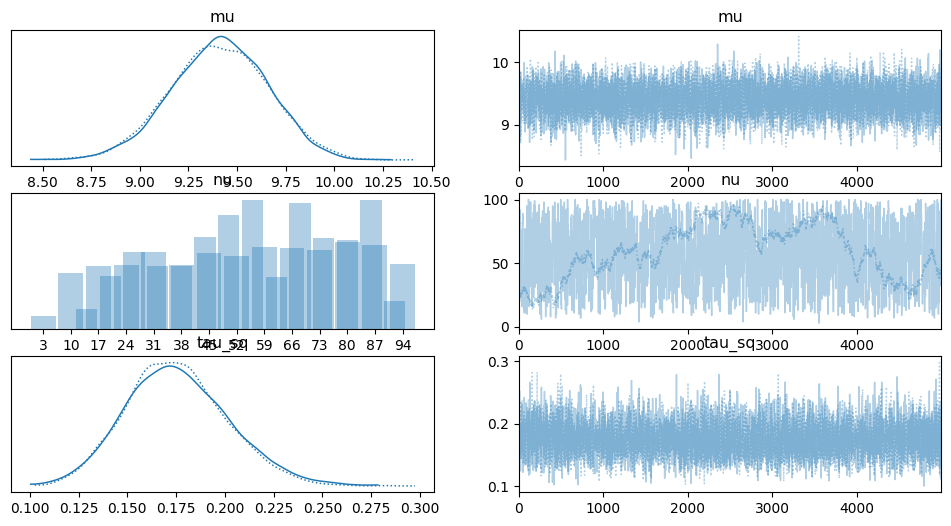

In [9]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata_HMC);
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ')

Autocorrelation for mu in HMC (MCMC) chain 0.11216841105098281
Autocorrelation for tau squared in HMC (MCMC) chain 0.2126261511898483
Autocorrelation for the degree of freedom in HMC (MCMC) chain 0.6291224645915848


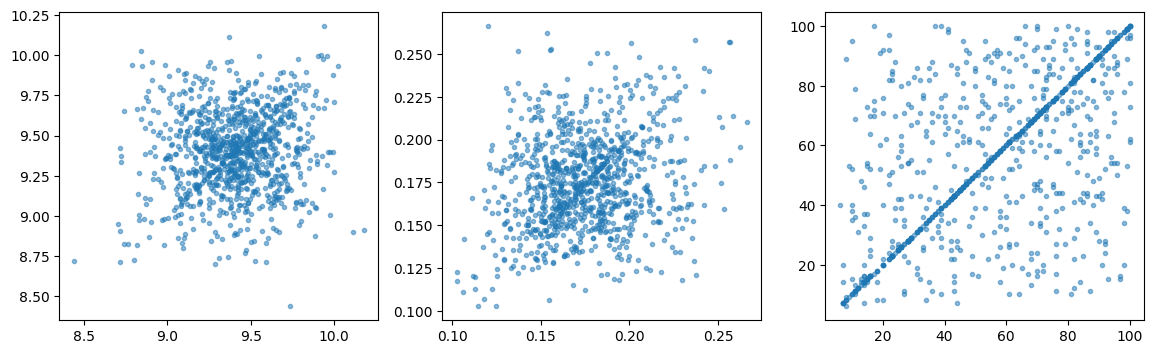

In [11]:
import numpy as np; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,3, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["mu"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC.posterior["mu"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for mu in HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = idata_HMC.posterior["tau_sq"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC.posterior["tau_sq"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for tau squared in HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = idata_HMC.posterior["nu"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC.posterior["nu"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[2].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for the degree of freedom in HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

In [12]:
import arviz as az;
print("number of MCMC samples:", idata_HMC.posterior['mu'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2) # https://python.arviz.org/en/stable/api/generated/arviz.ess.html

number of MCMC samples: 10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,9.41,0.25,8.93,9.85,0.00,0.00,7939.54,6048.22,1.00
nu,57.93,23.69,15.00,94.00,3.85,2.75,50.43,189.42,1.02
tau_sq,0.18,0.03,0.13,0.23,0.00,0.00,6773.07,6380.44,1.00


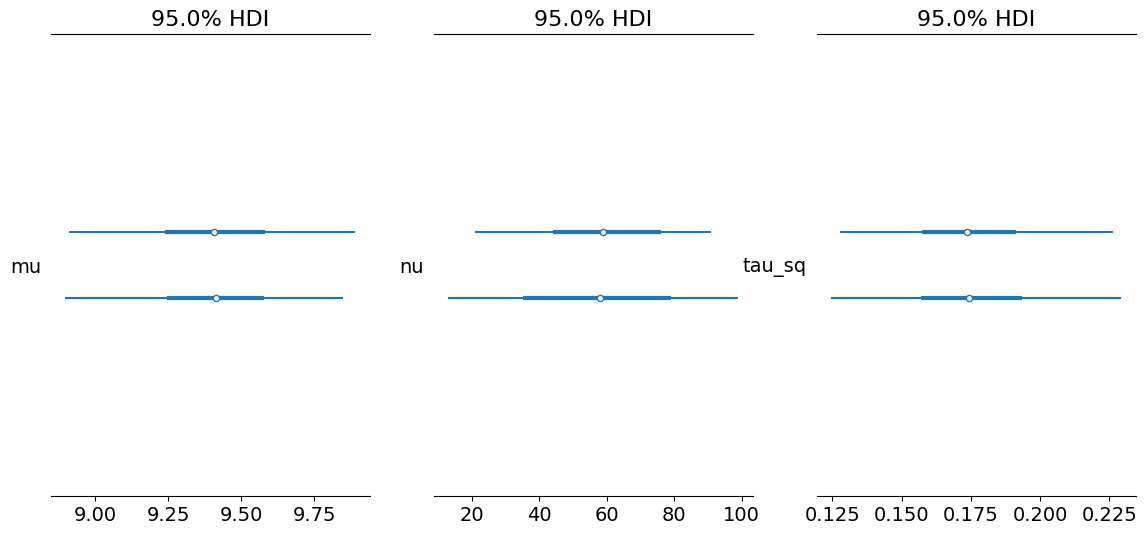

In [13]:
# 95% credible interval of mu, nu, and tau_sq
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,3, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["mu"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_HMC, var_names=["nu"], combined=False, hdi_prob=0.95, ax=ax[1]);
az.plot_forest(idata_HMC, var_names=["tau_sq"], combined=False, hdi_prob=0.95, ax=ax[2]);

# Homework #4 Part II: HMC Diagnostics

- Return to your posterior analysis in "Homework #4 Part I" and
report on (a) ***effective sample sizes***; (b) ***chain convergence measures***; (c) ***divergences***; (d) ***Metropolis-Hastings acceptance rates*** [see below for how to access these]; and (e) any other warnings or concers provided by `PyMC`

- Now examine the [Eight Schools](https://github.com/pointOfive/STA410_W24_StatisticalComputation/blob/main/Week3/STA410_W24_Week3_Demo_HMCwithPyMC.ipynb) example PyMC model and outputted results
    - Provide an analogous report regarding (a)-(e) above for the "centered" and "uncentered" Eight Schools models
        - *Hint: for (d) see `fit_C.sample_stats.acceptance_rate.values.flatten()` and `fit_NC.sample_stats.acceptance_rate.values.flatten()` and in the Eight Schools example*
    - From the perspective of ***curvature*** of the ***energy function*** (that is, how rapidly the ***log joint posterior distribution density*** changes for different values of its ***random variable (parameters)*** and the effectiveness of the ***HMC*** algorithm, explain why the "uncentered" paramterization of the model performs better than the "centered" parameterization
        - *Hint: see the previous two slides...*
- Review [this](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#model-checking) and [that](https://discourse.pymc.io/t/about-nuts-sampling-and-energy-plot/831) discussing the ***diagnostic plot*** which compares the ***observed energy proposal distribution*** versus the ***empirical energy distribution*** of the generated HMC samples
    - Use the code on the next slide to provide and interpret the ***diagnostic plot*** assessing ***energy proposals*** versus the empirical ***energy*** distribution to compare and contrast the "centered" and "uncentered" Eight Schools models in relation to you previous comparision of these two model parameterization in terms of ***energy function curvature*** and the effectiveness of the ***HMC*** algorithm... does this diagnostic support your previous conclusions in these regards?


Text(0.5, 1.0, 'Acceptance Rates')

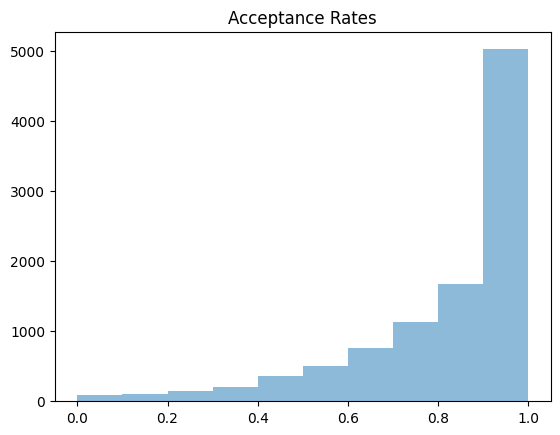

In [19]:
import matplotlib.pyplot as plt
plt.hist(idata_HMC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5)
plt.title('Acceptance Rates')

In HW4 Part I \
 a) The effective sample size for mu at the bulk is 7940 out of 10000 samples. The effective sample size for nu at the tail is 50 out of 10000 samples. The effective sample size for tau squared at the tail is 6773 out of 10000 samples. Notice that the number of effective sample sizes for the degree of freedom (nu) is relatively small compared to the 10000 number of iterations. This result is due to the high correlation 0.63 from the HMC chains. \
 b) Two chains for mu, nu, and tau squared generally converge because HMC split R-hats for the three corresponding parameters are all below 1.05. Thus, we can't conclude that there exist differences between the two chains. \
 c) Both of the chains diverge from the output in Pymc sampling with 5000 draws.\
 d) Notice that when the number of draws is 5000, the Metropolis-Hastings acceptance rates approximately lie between 0.9 and 1. It means that more than 90% of the proposed states with the number of draws equal to 5000 are accepted during the sampling process. \
 e) There doesn't exist any warning or concerns provided by PyMC.

Beginning of the Eight Schools Example

In [18]:
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [20]:
import pymc as pm
with pm.Model() as Centered_eight:
    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

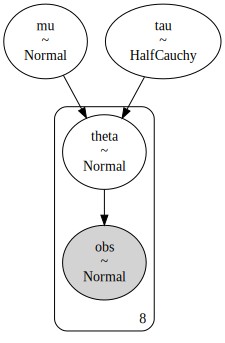

In [21]:
pm.model_to_graphviz(Centered_eight)

In [22]:
# This posterior distribution implied by this specification can be sampled from
# using HMC where the necessary auxiliary variables are added "under the hood"
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

In [23]:
# We can get some more information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

In [24]:
# We now see that the NUTS implementation (version of HMC) is being used to
# sample from the posterior distributions of our parameters [mu, tau, theta]
SEED = [20100420, 20134234]
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:NUTS: [mu, tau, theta]


INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 37 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [25]:
# As is seen above, there are many divergences because the specification above
# induces high curature in the energy, but the following alternative
# parameterization alleviates this problem.

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

In [26]:
with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})
# Now very few divergences... problem solved!

INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Sequential sampling (2 chains in 1 job)
INFO:pymc.sampling.mcmc:NUTS: [mu, tau, theta_t]


INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 27 seconds.
INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics


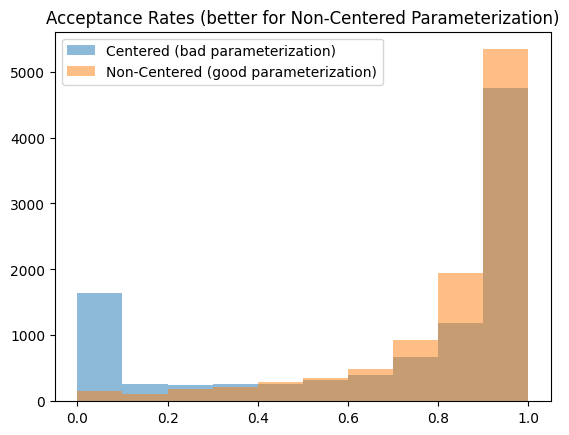

In [27]:
import matplotlib.pyplot as plt
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Centered (bad parameterization)');
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); plt.legend();

In [28]:
import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered,Non-Centered
mu,623.0,11120.0
tau,129.0,5121.0
theta[0],538.0,10859.0
theta[1],978.0,11965.0
theta[2],1575.0,11071.0
theta[3],965.0,12523.0
theta[4],1673.0,11294.0
theta[5],1769.0,10616.0
theta[6],415.0,11073.0
theta[7],1248.0,11415.0


For the "centered" and "uncentered Eight Schools models\
 a) The effective sample size for mu, tau, and eight thetas in the centered model is 623,129,538,978,1575,965,1673,1769,415, and 1248. On the other hand, the effective sample size for mu, tau, and eight thetas in the non-centered model is 11120,5121,10859,11965,11071,12523,11294,10616,11073, and 11415.  Notice that the number of effective sample sizes for the uncentered model is significantly larger than that for the centered model. This result comes from the fact that autocorrelations for the parameters in the uncentered model are smaller than the corresponding autocorrelations in the centered model. \
 b) Higher effective sample sizes for the parameters in the non-centered model imply that the non-centered model has better convergence. \
 c) Both of the chains diverge from the output in Pymc sampling.\
 d) Notice that when the number of draws is 5000, the Metropolis-Hastings acceptance rates for the non-centered model approximately lie between 0.9 and 1. It means that more than 90% of the proposed states with the number of draws equal to 5000 are accepted during the sampling process. There exists an issue connected to the centered model because the acceptance rate for the centered model is not stable under 2000 draws. \
 e) There doesn't exist any warning or concerns provided by PyMC since four chains are run for robust computation of convergence diagnostics in fit_C and fit_NC.

The uncentered parameterization of a PyMC model tends to perform better than the centered parameterization from the perspective of the curvature of the energy function and the effectiveness of the HMC algorithm. \
Regarding the curvature of the energy function, highly correlated parameters caused by the centered parameterization lead to elongated and curved trajectories in the parameter space. Since the curvature of the energy function may vary significantly along these trajectories, it is challenging for the HMC algorithm to efficiently explore the space. \
Regarding the effectiveness of the HMC algorithm, the centered model needs to make each step really tiny to prevent the proposals from going away from previous values which leads to slow convergence and increased computational cost.

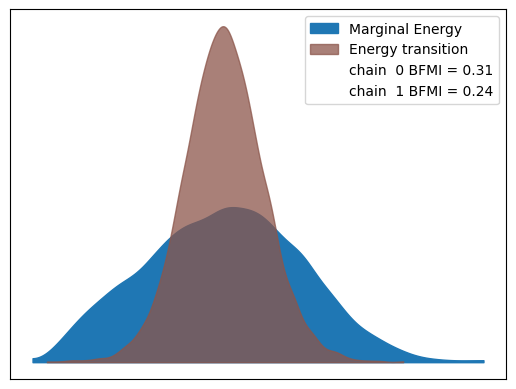

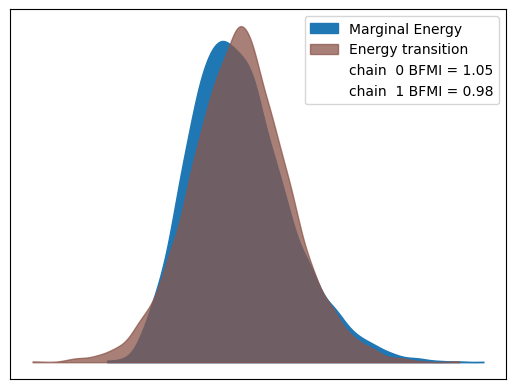

In [29]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

The energy plot shows two density estimates: one is the observed energy proposal distribution and the other is the empirical energy distribution of the generated HMC samples. According to information provided on this website https://discourse.pymc.io/t/about-nuts-sampling-and-energy-plot/831, we want the two distributions (energy and energy transition) as close as possible. It can be observed from the top two plots that the fit_MC model's marginal energy distribution is closer to the energy transition distribution compared to its counterpart. Moreover, the energy transition distribution is much narrower than the marginal energy distribution for fit_C model which means fit_C model doesn't have enough energy to explore the whole parameter space and the posterior estimation is likely biased. Therefore, results from the two energy plots align with my previous conclusions about the energy function curvature and the effectiveness of the HMC algorithm.
